# Peer-graded Assignment: Центральная предельная теорема своими руками

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns

sns.set()
sns.set_style("whitegrid")

%matplotlib inline

В этом задании вам предстоит проверить работу центральной предельной теоремы, а также поработать с генерацией случайных чисел и построением графиков в Питоне.

Выберите ваше любимое непрерывное распределение (чем меньше оно будет похоже на нормальное, тем интереснее; попробуйте выбрать какое-нибудь распределение из тех, что мы не обсуждали в курсе). Сгенерируйте из него выборку объёма 1000, постройте гистограмму выборки и нарисуйте поверх неё теоретическую плотность распределения вашей случайной величины (чтобы величины были в одном масштабе, не забудьте выставить у гистограммы значение параметра normed=True).

*__Примечание__. Я решил поупражняться с построением графиков и ради интереса решил взять несколько разных распределений (Стьюдента, Хи-квадрат, экспоненциальное и Лапласа).*

In [2]:
# Defines auxilary functions. For a particular random distribution, defined by some parameter (e.g. 'degree of freedom' or 'scale'),
# it returns a pair (legend; the random variable).

def get_t(df):
    return 't({0})'.format(df), sts.t(df)

def get_chi2(df):
    return '$\chi^2_{{{0}}}$'.format(df), sts.chi2(df)

def get_expon(lam):
    return 'Exp({0})'.format(lam), sts.expon(scale=lam)

def get_laplace(a):
    return 'Laplace({0})'.format(a), sts.laplace(scale=a)

In [5]:
from itertools import chain

# generates different pairs (legend; random variable) for diff random distributions.
students = map(get_t, [1.0, 2.0, 3.0, 5.0])
chi2s = map(get_chi2, [1.5, 2.0, 4.0, 10.0,])
expons = map(get_expon, [1.0])
laplaces = map(get_laplace, [1.0])

# merges 'em into one list
rvs = list(chain(students, chi2s, expons, laplaces))

In [6]:
# Defines function, which for a given random variable, its legend and figure axis, does following:
#   1. samples values and plots sample histogram, cutting out outliers - i.e. values outside [1, 99] interquartile range,
#   3. plots expected PDF (prob distr. func) with line

def sample_and_plot(legend, rv, ax):
    left = rv.ppf(0.01)
    right = rv.ppf(0.99)
    sample_count = 1000
    bins = 20

    xs = np.linspace(left, right, 200)
    y_pdf = rv.pdf(xs)
    y_rvs = np.array([x for x in rv.rvs(sample_count) if x >= left and x <= right])

    _ = ax.plot(xs, y_pdf, label='pdf', alpha=0.8)
    _ = ax.hist(y_rvs, bins=bins, density=True, alpha=0.6, label='sample'.format(legend))
    
    ax.legend(loc='upper right', prop={'size': 15})
    ax.text(0.1, 0.9, '{0}'.format(legend), transform=ax.transAxes, fontsize=16)

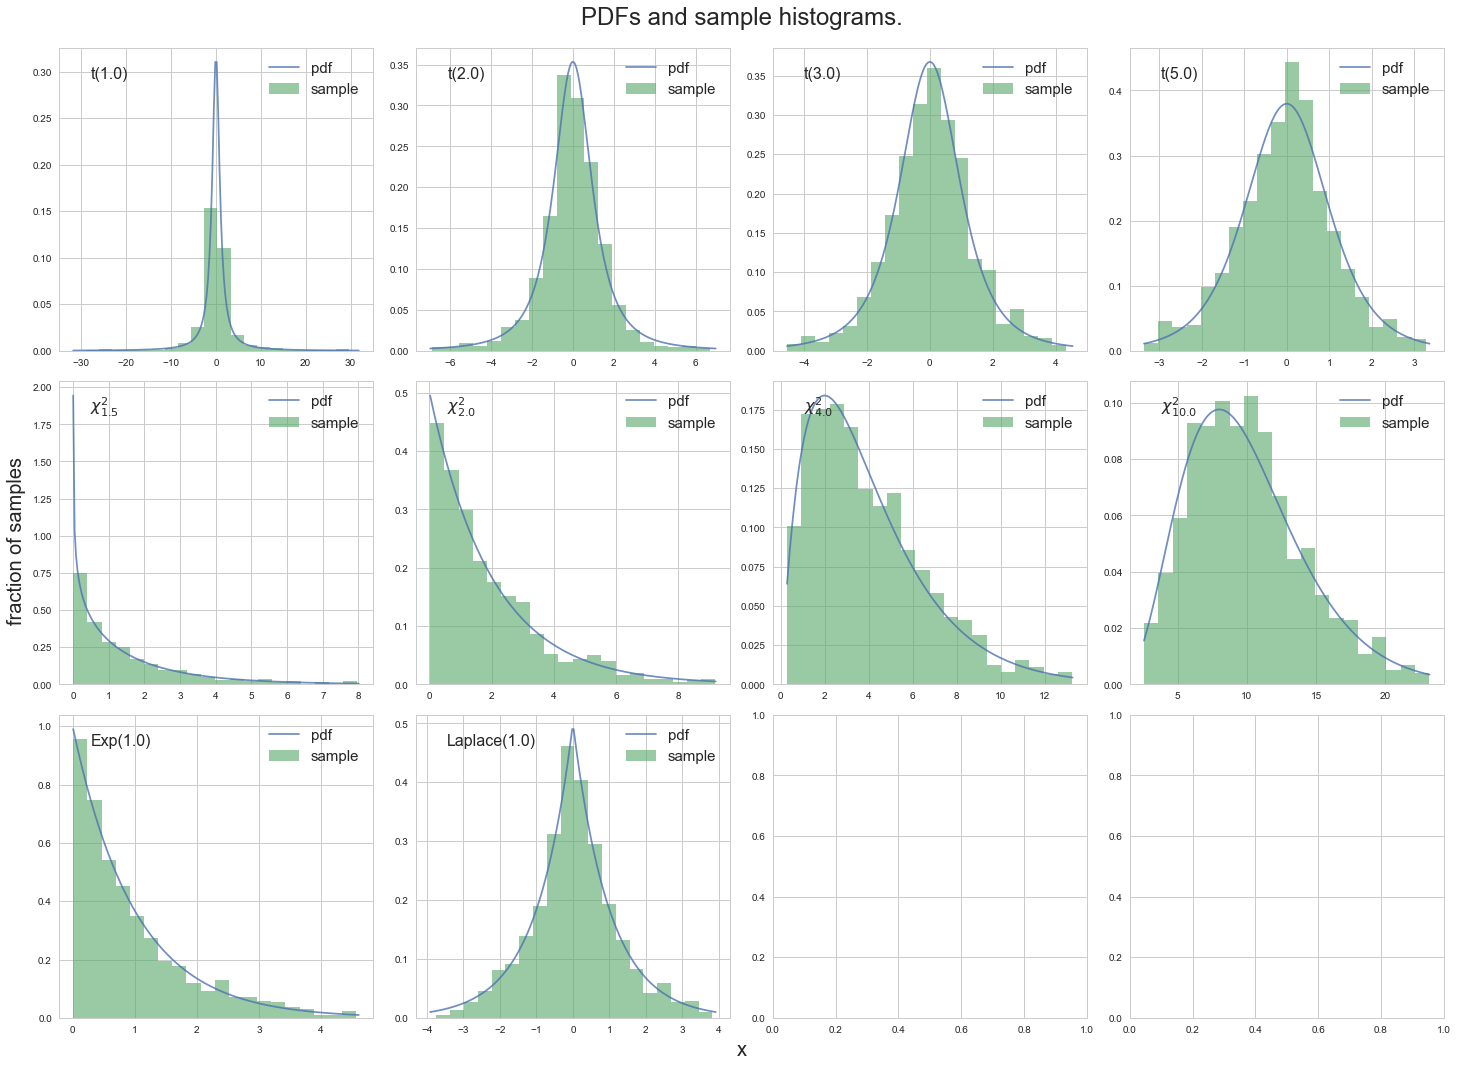

In [9]:
from math import ceil

# defines plot dimensions
plot_cols = 4
plot_rows = ceil(len(rvs) / plot_cols)

# defines the plotting figure and calls sample-n-plot auxiliary function for every random variable.
fig, axes = plt.subplots(plot_rows, plot_cols, )

for ind, p in enumerate(rvs):
    legend, rv = p
    sample_and_plot(legend, rv, axes[ind // plot_cols, ind % plot_cols])
    
fig.set_size_inches(20., 14.)
fig.suptitle('PDFs and sample histograms.', x=0.5, y=1.03, fontsize=24)
fig.text(0.5, -0.01, 'x', ha='center', transform=fig.transFigure, fontsize=20)
fig.text(-0.01, 0.5, 'fraction of samples', va='center', rotation='vertical', fontsize=20)
fig.tight_layout()

___

Ваша задача — оценить распределение выборочного среднего вашей случайной величины при разных объёмах выборок. Для этого при трёх и более значениях n (например, 5, 10, 50) сгенерируйте 1000 выборок объёма n и постройте гистограммы распределений их выборочных средних. Используя информацию о среднем и дисперсии исходного распределения (её можно без труда найти в википедии), посчитайте значения параметров нормальных распределений, которыми, согласно центральной предельной теореме, приближается распределение выборочных средних. 

__Обратите внимание__: для подсчёта значений этих параметров нужно использовать именно теоретические среднее и дисперсию вашей случайной величины, а не их выборочные оценки. Поверх каждой гистограммы нарисуйте плотность соответствующего нормального распределения (будьте внимательны с параметрами функции, она принимает на вход не дисперсию, а стандартное отклонение).

Опишите разницу между полученными распределениями при различных значениях n. Как меняется точность аппроксимации распределения выборочных средних нормальным с ростом n?

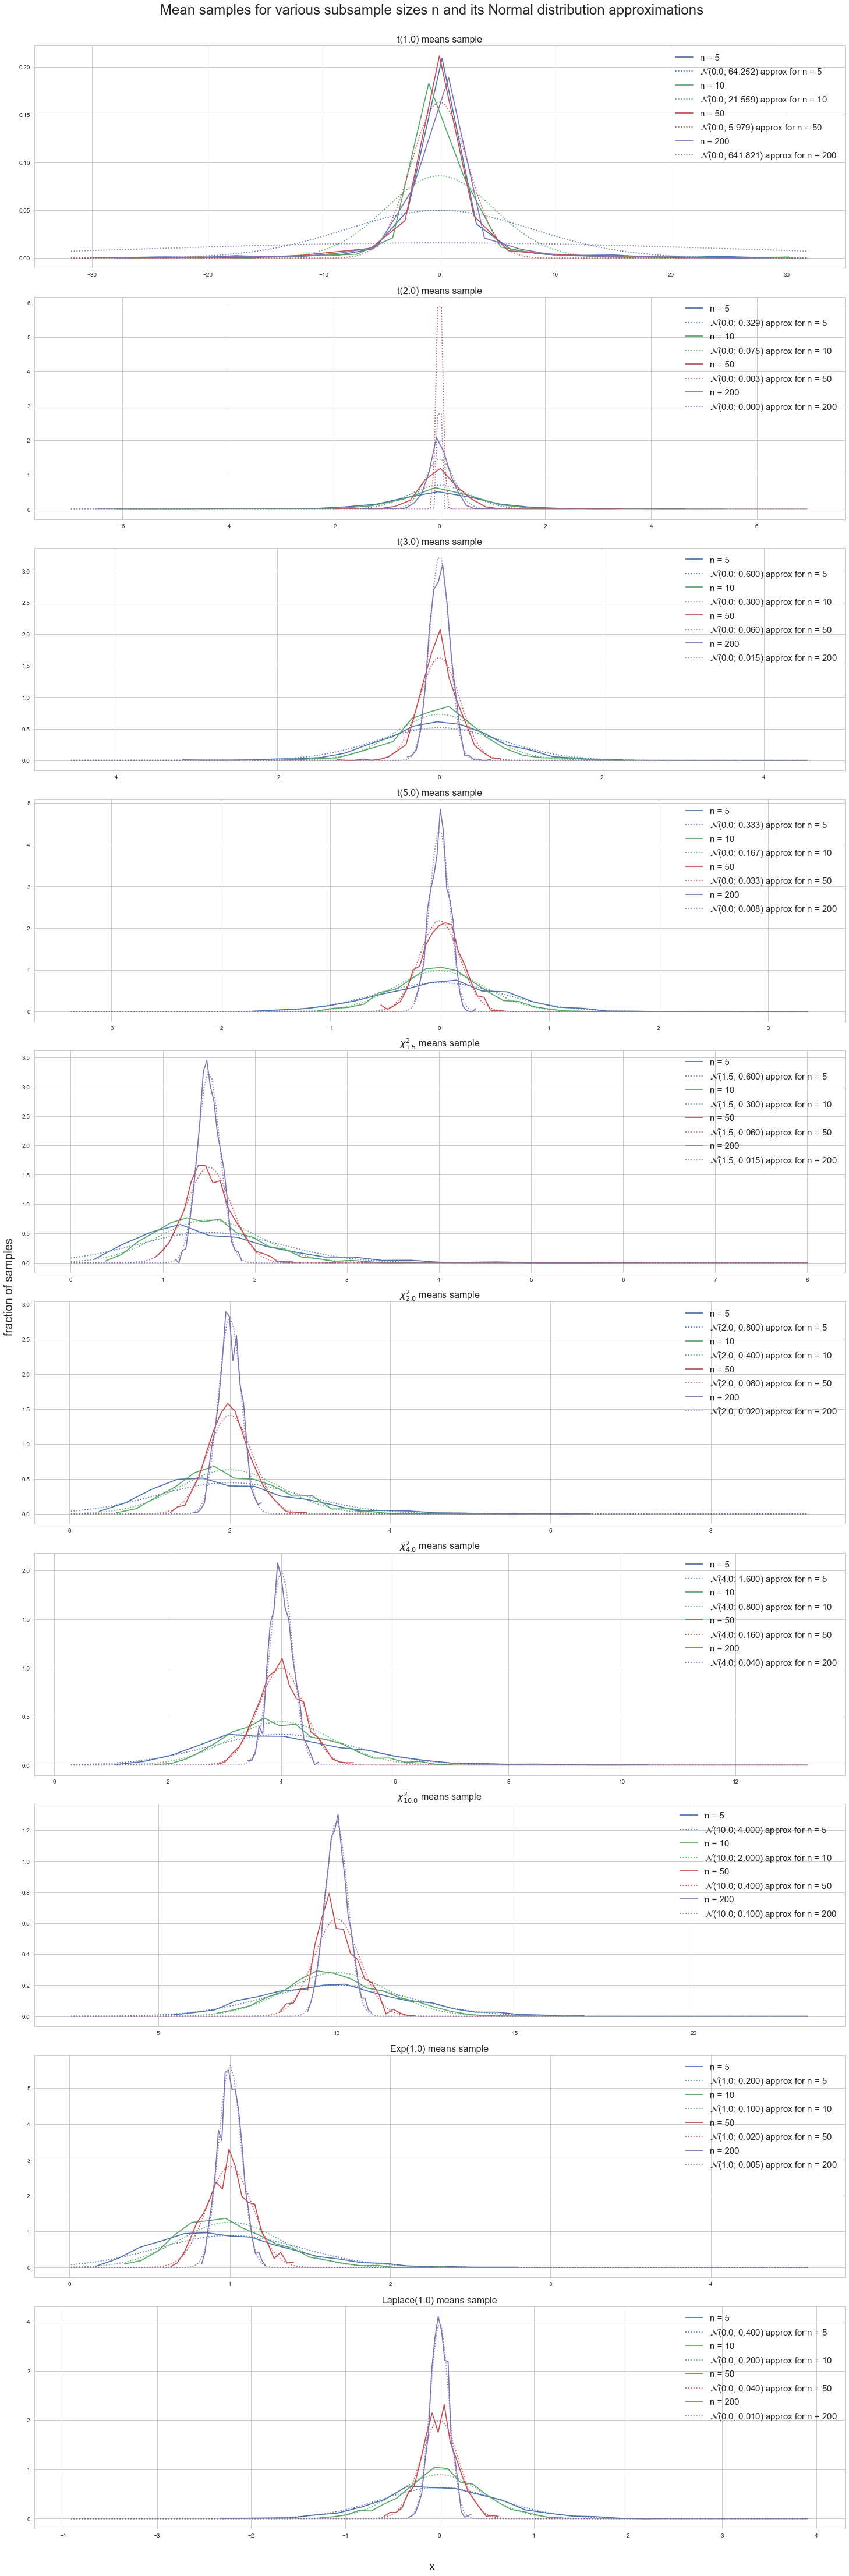

In [10]:
from math import sqrt

# Samples means rv subsamples and plots its histogram (with line based on histogram bin centers) and also plots Normal Distr approx
# for a given random variable, size of every subsample, figure axis, rv's legend and color of plotting line.
def sample_means_and_plot(rv, n, ax, legend, color):
    left = rv.ppf(0.01)
    right = rv.ppf(0.99)    

    # samples means
    epochs = 1000
    means = [np.mean(rv.rvs(n)) for _ in range(epochs)]
    
    # gets expected mean and std for the sample (I'm cheating here by taking it from rv objects instead of Wikipedia ;). 
    # Note: a random variable might have infinite mean or std, e.g. t-student(1.0), which is a 
    # Cauchy distribution, has variance = +inf. In this case an empirical value from the sample is used.
    mean = rv.mean() if np.isfinite(rv.mean()) else np.mean(means)
    std = (rv.std() if np.isfinite(rv.std()) else np.std(means)) / sqrt(n)
    
    # cuts outliers to get tighter x-axis range and better histogram bins distribution
    means = [x for x in means if x >= left and x <= right]
    
    # builds histogram for the sample of means
    ys, bin_edges = np.histogram(means, bins=20, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
        
    # plots straight line plot based on the histogram bin centers for the sample of means
    ax.plot(bin_centers, ys, '-', label='n = {0}'.format(n), color=color)
    
    # plots normal distribution approximation for the sample of means with the dashed line of the same color
    xs = np.linspace(left, right, 200)
    ys = sts.norm(mean, std).pdf(xs)
    ax.plot(xs, ys, ':', label='$\mathcal{{N}}$({1}; {2:.3f}) approx for n = {0}'.format(n, mean, std**2), color=color)
    
    ax.legend(loc='upper right', prop={'size': 15})

# Samples and plots hist and approx for different sizes of subsamples for a given random variable.
def test_rv(rv, ax, legend, palette):
    ns = [5, 10, 50, 200]
    for i, n in enumerate(ns):
        sample_means_and_plot(rv, n, ax, legend, palette[i])
        
    #ax.text(0.02, 0.9, '{0} means sample'.format(legend), transform=ax.transAxes, fontsize=16)
    ax.set_title('{0} means sample'.format(legend), fontsize=16)
    

# defines figure dimensions
plot_cols = 1
plot_rows = ceil(len(rvs) / plot_cols)
fig, axes = plt.subplots(plot_rows, plot_cols)
palette = sns.color_palette()

# plots for every random variable 
for ind, p in enumerate(rvs):
    legend, rv = p
    test_rv(rv, axes[ind // plot_cols], legend, palette) #, ind % plot_cols
    
fig.set_size_inches(20., 60.)
fig.suptitle('Mean samples for various subsample sizes n and its Normal distribution approximations', x=0.5, y=1.01, fontsize=24)
fig.text(0.5, -0.01, 'x', ha='center', transform=fig.transFigure, fontsize=20)
fig.text(-0.01, 0.5, 'fraction of samples', va='center', rotation='vertical', fontsize=20)
fig.tight_layout()

Выводы:

- t(1.0) имеет вырожденную дисперсию, поэтому аппроксимация так себе. Более того, видно, что гистограма уже, чем ожидаемая, основанная на эмпирическом значении дисперсии. С увеличением параметра `n` степеней свободы, распределение становится менее вырожденным, и оценка нормальным распределением весьма точно описывает наблюдаемые гистограммы.
- для несимметричных распределений $\chi^2_k$ и Exp(k) при небольших размерах подвыборок наблюдается небольшое отклонение от среднего в сторону перекоса (гистограмма чуть левее графика аппроксимации). Что, в общем, не так удивительно.
- ну по тому, что я вижу, могу сделать вывод, что точность аппроксимации хорошая даже при минимальном размере подвыборки (5). Хотя, учитывая, что результаты основаны на аж 1000 эпохах, наверное, это тоже не удивительно. Разница лишь в ширине горба - с увеличением размера подвыборок мы больше уверены в оценке средним, т.е. график сильнее вытягивается иглой в точке матожидания. Собственно, в этом и есть главный вывод - на небольших размерах подвыборок хвосты могут быть слишком большими, а следовательно и результирующий доверительный интервал, и этого будет недостаточно, чтобы получить вразумительную оценку.

___

Дальше я просто играюсь. Ниже гистограммы без фильтрации выбросов.

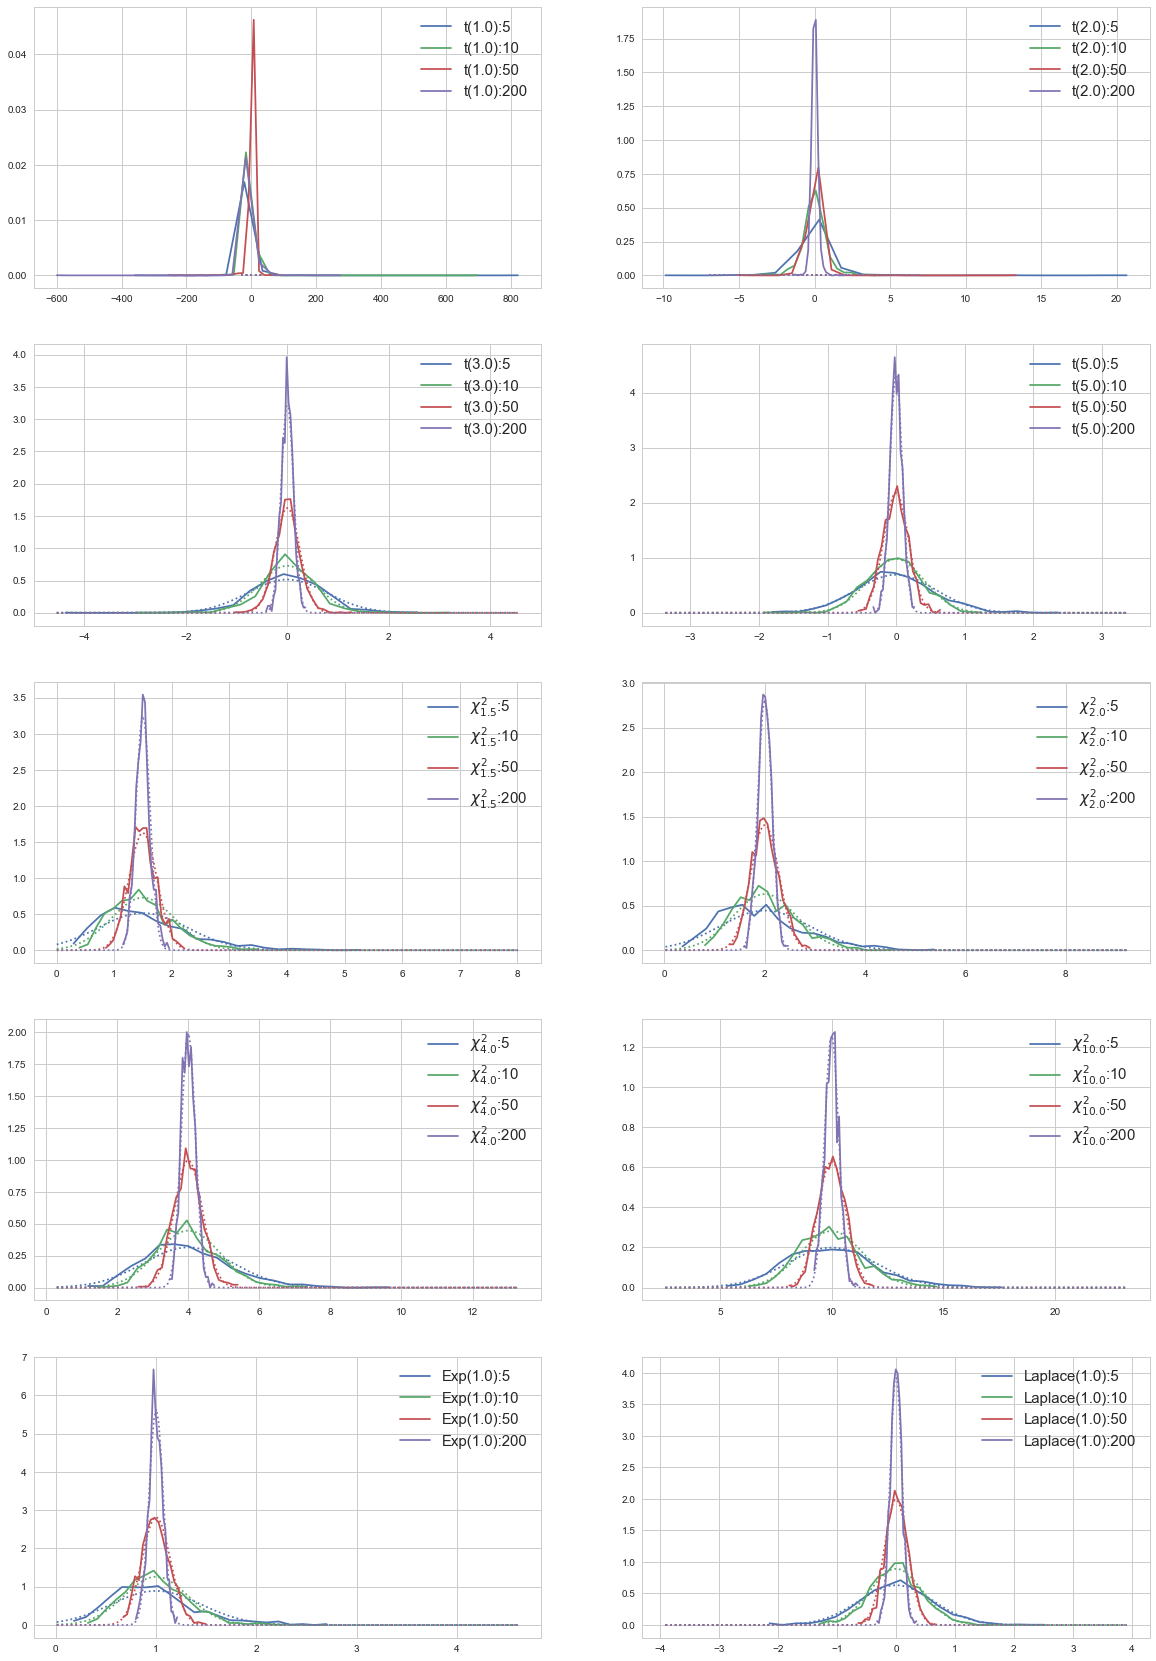

In [11]:
from math import sqrt

def run_sampler(rv, n, ax, legend, color):
    left = rv.ppf(0.01)
    right = rv.ppf(0.99)
    
    means = [np.mean(rv.rvs(n)) for _ in range(epochs)]
    #means = [x for x in means if x >= left and x <= right]
    ys, bin_edges = np.histogram(means, bins=22, density=True)    
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    ax.plot(bin_centers, ys, '-', label=legend + ':{0}'.format(n), color=color)
    ax.legend(loc='upper right', prop={'size': 15})
    
    mean = rv.mean()
    std = rv.std()
    xs = np.linspace(left, right, 200)
    ys = sts.norm(mean, std/sqrt(n)).pdf(xs)
    ax.plot(xs, ys, ':', color=color)

def test_rv(rv, ax, legend, palette):
    for i, n in enumerate(ns):
        run_sampler(rv, n, ax, legend, palette[i])
    
    
ns = [5, 10, 50, 200]
epochs = 1000
plot_cols = 2
plot_rows = ceil(len(rvs) / plot_cols)
fig, axes = plt.subplots(plot_rows, plot_cols)
palette = sns.color_palette()

for ind, p in enumerate(rvs):
    legend, rv = p
    test_rv(rv, axes[ind // plot_cols, ind % plot_cols], legend, palette)
    
fig.set_size_inches(20., 30.)